In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

logs = # TO FILL
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
log_dir = f"{logs}/resultats_11-23/"
save_dir = f"{processed_log_dir}/maskrcnn/"
job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"
energy = pd.read_csv(energy_file).drop(columns=["Unnamed: 0"])

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_58159/4166054807.py:9: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  energy = pd.read_csv(energy_file).drop(columns=["Unnamed: 0"])


In [2]:
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])

In [3]:
jobs.columns

Index(['job', 'energy_kWh', 'energy_joule',
       'energy_consumption_since_previous_measurement_milliJ', 'job_id',
       'file', 'start_time_ms', 'sub_seed', 'training_start_time_ms',
       'end_time_ms', 'epoch_nb', 'block_nb', 'eval_nb',
       'mllog_submission_benchmark', 'mllog_submission_org',
       'mllog_submission_division', 'mllog_submission_status',
       'mllog_submission_platform', 'mllog_seed', 'mllog_d_batch_size',
       'mllog_global_batch_size', 'mllog_num_image_candidates',
       'mllog_gradient_accumulation_steps', 'mllog_opt_name',
       'mllog_opt_base_learning_rate', 'mllog_opt_learning_rate_warmup_steps',
       'mllog_opt_learning_rate_warmup_factor',
       'mllog_opt_learning_rate_decay_factor',
       'mllog_opt_learning_rate_decay_steps', 'mllog_min_image_size',
       'mllog_max_image_size', 'mllog_train_samples', 'mllog_tracked_stats',
       'mllog_throughput', 'mllog_eval_samples', 'mllog_eval_accuracy',
       'node_nb'],
      dtype='object')

In [4]:
jobs["total_batch_size"]=jobs["mllog_d_batch_size"]*jobs["node_nb"]*8


In [5]:
job_list = list(jobs.job_id)
np.array(job_list)

array([126852, 126853, 126854, 126855, 126856, 126857, 126858, 126859,
       126860, 126861, 126862, 126863])

In [6]:
def plot_energy_components(ax ,energy_df, node, energy_col, legend=False):
    for label, df in energy_df.groupby(["device_index"]):
        df.plot(
            x="timestamp", 
            y=energy_col, 
            ax=ax, 
            label="GPU energy "+str(label),
            )
    for label, df in energy_df.groupby(["domain", "socket"]):
        df.plot(
            x="timestamp", 
            y=energy_col, 
            ax=ax, 
            label=label,
            )
    if legend:
        ax.legend(
            bbox_to_anchor=(0.5,-0.1), 
            loc='upper center',
            fontsize=20,
            ncol=2
        )
    else:
        ax.get_legend().remove()
    ax.set_title(node)
    return ax

def plot_utilization(ax, plot_df):
    plot_df[
        (plot_df["device_index"].notna())
        
        ].plot(x="timestamp", y="global_utilization_percent", ax=ax, label="GPU utilization")
    plot_df[
        (plot_df["device_index"].notna())
        ].plot(x="timestamp", y="global_memory_percent", ax=ax, label="GPU mem utilization")
    plot_df[
        (plot_df["utilization_percent"].notna())
        ].groupby("timestamp").mean().plot(ax=ax, y="utilization_percent", label="CPU avg utilization")
    # ax.legend(
    #     bbox_to_anchor=(0.5,-0.1), 
    #     loc='upper center',
    #     fontsize=20,
    #     ncol=2
    # )
    ax.get_legend().remove()
    return ax



In [7]:
max_y = 0
max_x = 0
for job in job_list:
    energy_df = energy[energy["job"]==job]
    max_job_energy = energy_df["energy_consumption_since_previous_measurement_milliJ"].max()
    max_job_time = energy_df["timestamp"].max() - energy_df["timestamp"].min()
    if max_y<max_job_energy:
        max_y=max_job_energy
    if max_x<max_job_time:
        max_x=max_job_time
max_x, max_y

(3029476, 280087.0)

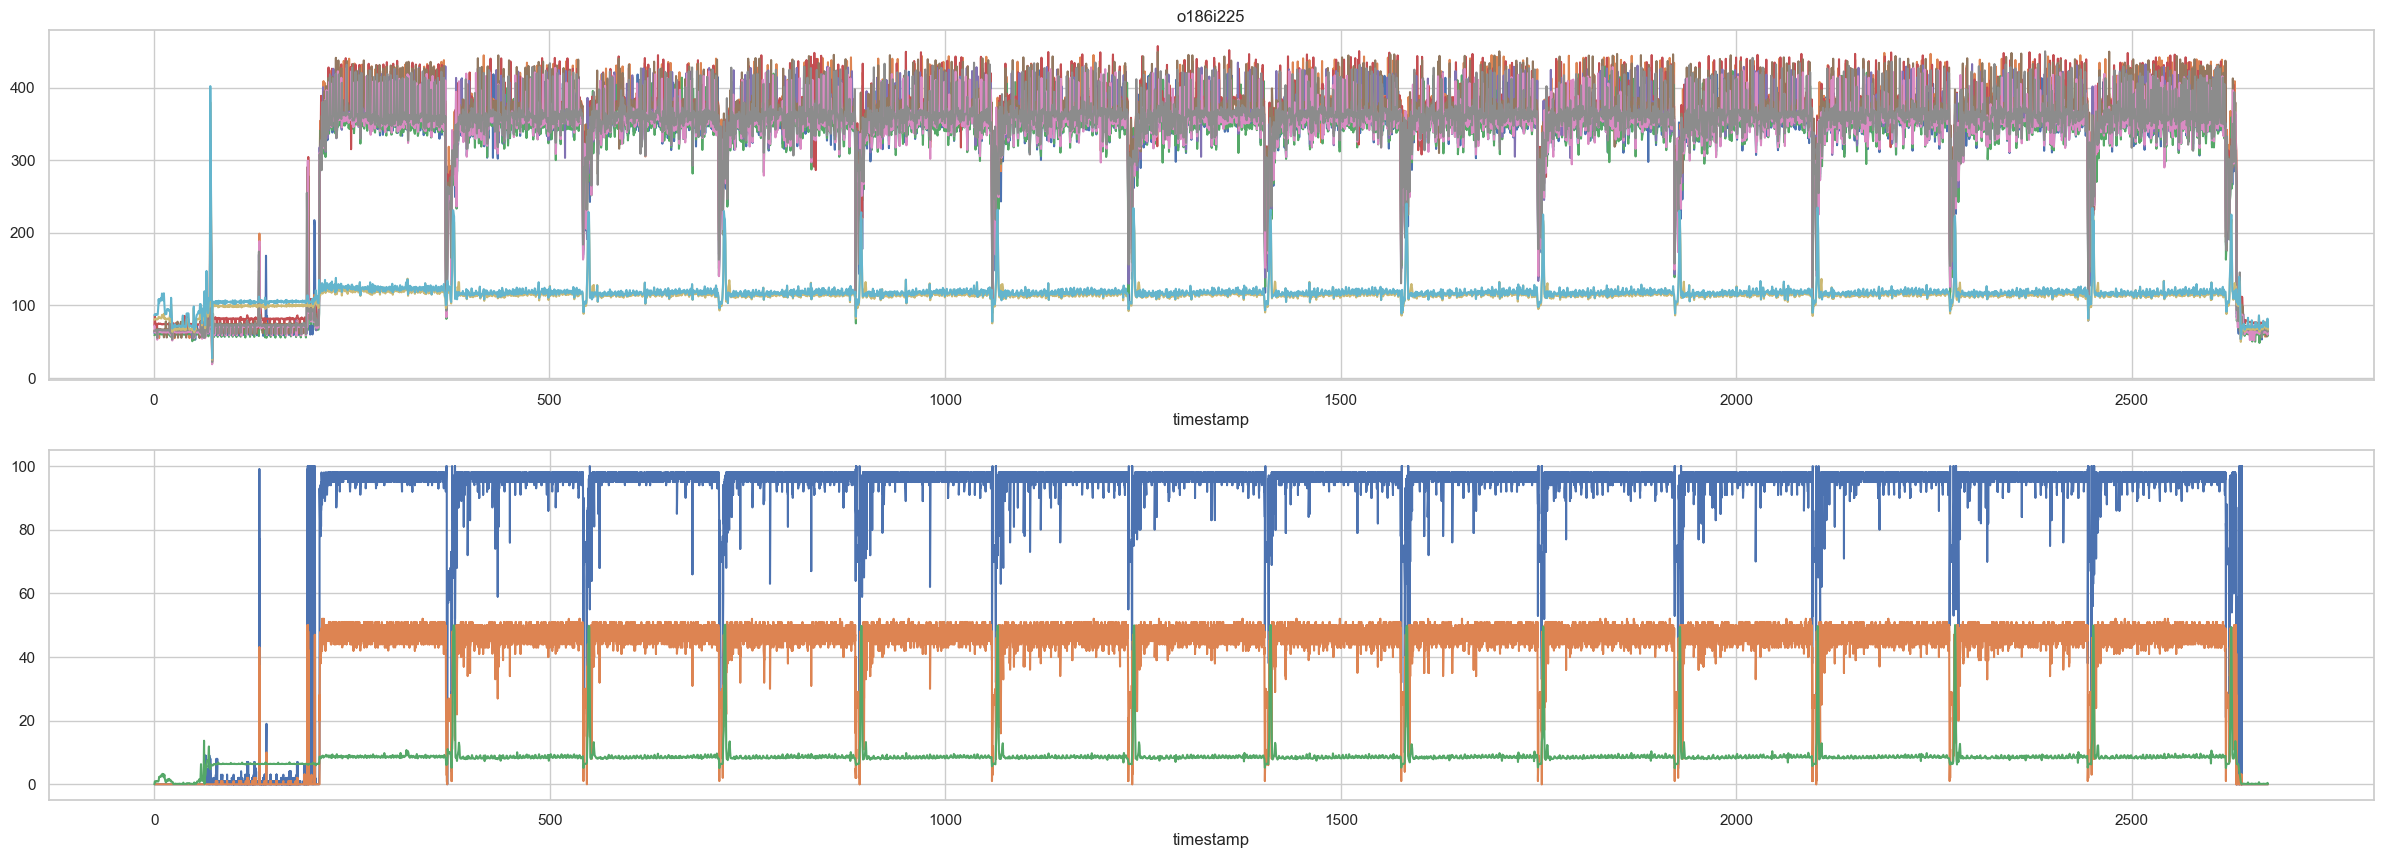

In [8]:


for job in job_list[:1]:
    energy_job = energy[energy["job"]==job]
    nodes = energy_job.node.unique()
    node_nb = len(nodes)
    # batch, target, sample, seed = jobs[jobs["job"]==job][["total_batch_size", "sub_target-acc", "sub_num-sample", "sub_seed"]].values[0]
    fig, ax = plt.subplots(2, node_nb, figsize=(30,10))
    for i, node in enumerate(nodes):
        
        ax1 = ax[0,i] if node_nb>1 else ax[0]
        ax2 = ax[1,i] if node_nb>1 else ax[1]
        plot_df = energy_job[energy_job["node"]==node]
        
        avg_df = plot_df[["energy_consumption_since_previous_measurement_milliJ", "timestamp", "device_index", "domain", "socket", "global_utilization_percent", "global_memory_percent", "utilization_percent"]].copy()
        diff_df = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]].diff()
        diff_df.rename(columns={"timestamp":"diff"}, inplace=True)
        diff_df["timestamp"] = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]]
        avg_df = avg_df.merge(diff_df, on="timestamp")
        avg_df["power(W)"]=avg_df["energy_consumption_since_previous_measurement_milliJ"]/avg_df["diff"]  # time in msec
        avg_df["timestamp"] = (avg_df["timestamp"]-avg_df["timestamp"].min())*1e-3

        ax1 = plot_energy_components(ax1, avg_df, node, 'power(W)')
        # ax1.set_ylim(0, max_y*1.5)
        # ax1.set_xlim(-max_x*1e-3*0.01, max_x*1e-3*1.01)
        ax2 = plot_utilization(ax2, avg_df)
        # ax2.set_xlim(-max_x*1e-3*0.01, max_x*1e-3*1.01)
    # plt.suptitle(f"Batch-size: {batch}, target: {target}, sample nb: {sample}, seed: {seed}")

In [9]:
# Let's

# Let's aggregate the results


<!-- avg_df = plot_df[["energy_consumption_since_previous_measurement_milliJ", "timestamp", "device_index", "domain", "socket", "global_utilization_percent", "global_memory_percent", "utilization_percent"]].copy()
diff_df = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]].diff()
diff_df.rename(columns={"timestamp":"diff"}, inplace=True)
diff_df["timestamp"] = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]]
avg_df = avg_df.merge(diff_df, on="timestamp")
avg_df["power(W)"]=avg_df["energy_consumption_since_previous_measurement_milliJ"]/avg_df["diff"]  # time in msec
avg_df["timestamp"] = (avg_df["timestamp"]-avg_df["timestamp"].min())*1e-3 -->

   

In [10]:
job_list[0]

126852

In [11]:
ilo_path = f"{log_dir}/maskrcnn/{job_list[0]}/o186i225/ilo_power.csv" 
ilo_power = pd.read_csv(ilo_path)
ilo_power

,timestamp,power_watt
0,1699545993,1169
1,1699546004,1199
2,1699546014,1225
3,1699546024,1206
4,1699546034,1119
...,...,...
261,1699548620,3082
262,1699548631,2770
263,1699548641,2028
264,1699548651,1177


In [12]:
power = pd.DataFrame()
ilo_power = pd.DataFrame()
for job in job_list[-10:]:
    power_job = pd.DataFrame()
    energy_job = energy[energy["job"]==job]
    ecol = "energy_consumption_since_previous_measurement_milliJ"
    
    power_job = energy_job[energy_job[ecol].notna()].groupby("timestamp").sum()[[ecol, "job"]].reset_index()
    power_job["timestamp(sec)"] = (power_job["timestamp"]-power_job["timestamp"].min())*1e-3
    power_job["power(W)"]=power_job[ecol]*1e-3/power_job["timestamp(sec)"].diff()   
    
    power = pd.concat([power, power_job])
    
    ilo_path = f"{log_dir}/maskrcnn/{job}/o186i225/ilo_power.csv" 
    ilo = pd.read_csv(ilo_path)
    ilo["job"]=job
    ilo["timestamp(sec)"] = (ilo["timestamp"]-power_job["timestamp"].min()*1e-3)
    ilo_power = pd.concat([ilo_power, ilo]) 


In [13]:
energy[energy["job"]==job]

,timestamp,device_index,energy_consumption_since_previous_measurement_milliJ,instantaneous_power_milliW,global_utilization_percent,global_memory_percent,node,job,domain,socket,cpu,utilization_percent,energy_joule,energy_kWh,timestamps_msec
282848,1699576200985,0.0,38021.0,62949.0,0.0,0.0,o186i225,126863,NaN,NaN,NaN,NaN,38.021,0.000011,-58015.0
282849,1699576200985,1.0,40653.0,67055.0,0.0,0.0,o186i225,126863,NaN,NaN,NaN,NaN,40.653,0.000011,-58015.0
282850,1699576200985,2.0,36213.0,59966.0,0.0,0.0,o186i225,126863,NaN,NaN,NaN,NaN,36.213,0.000010,-58015.0
282851,1699576200985,3.0,53034.0,75246.0,0.0,0.0,o186i225,126863,NaN,NaN,NaN,NaN,53.034,0.000015,-58015.0
282852,1699576200985,4.0,38892.0,64397.0,0.0,0.0,o186i225,126863,NaN,NaN,NaN,NaN,38.892,0.000011,-58015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611607,1699578880142,NaN,NaN,NaN,NaN,NaN,o186i225,126863,NaN,NaN,cpu123,0.0,NaN,NaN,2621142.0
5611608,1699578880142,NaN,NaN,NaN,NaN,NaN,o186i225,126863,NaN,NaN,cpu124,0.0,NaN,NaN,2621142.0
5611609,1699578880142,NaN,NaN,NaN,NaN,NaN,o186i225,126863,NaN,NaN,cpu125,0.0,NaN,NaN,2621142.0
5611610,1699578880142,NaN,NaN,NaN,NaN,NaN,o186i225,126863,NaN,NaN,cpu126,0.0,NaN,NaN,2621142.0


In [14]:
power["job"] = (power.job*1e-1).astype(int)

In [15]:
ilo_power

,timestamp,power_watt,job,timestamp(sec)
0,1699551413,1188,126854,-0.866
1,1699551423,1206,126854,9.134
2,1699551433,1232,126854,19.134
3,1699551443,1216,126854,29.134
4,1699551453,1131,126854,39.134
...,...,...,...,...
262,1699578837,3084,126863,2636.015
263,1699578847,3213,126863,2646.015
264,1699578857,2781,126863,2656.015
265,1699578868,1247,126863,2667.015


/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

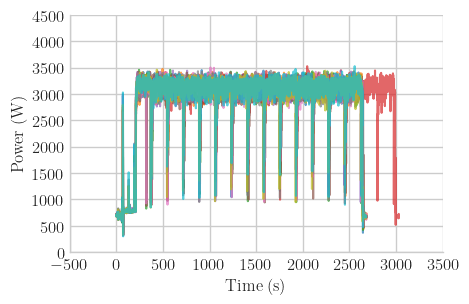

In [25]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(15,8))
ax = sns.relplot(
    x="timestamp(sec)", 
    y="power(W)", 
    data=power.reset_index(), 
    hue="job", kind="line", 
    palette="tab10",
    height=3, aspect=12/8,alpha=0.7
    )
# ax.set(title="Power consumption of dlrm training")
ax._legend.remove()
FONTSIZE = 12
ax.set_xlabels("Time (s)", fontsize=FONTSIZE)
ax.set_ylabels("Power (W)", fontsize=FONTSIZE)
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set(ylim=(0, 4500))
ax.set_yticklabels(fontsize=FONTSIZE)
ax.savefig(f"{graph_dir}/maskrcnn.png", dpi=300)

In [17]:
min = 300
max = 2500
avg_power = power[(power["timestamp(sec)"]>min)&(power["timestamp(sec)"]<max)].groupby(["job"])["power(W)"].mean().reset_index()
avg_ilo_power = ilo_power[(ilo_power["timestamp(sec)"]>min)&(ilo_power["timestamp(sec)"]<max)].groupby(["job"])["power_watt"].mean().reset_index()


In [18]:
avg_power.agg(["mean", "std"])

,job,power(W)
mean,126858.50000,3105.767994
std,3.02765,3.307845


In [19]:
avg_ilo_power.agg(["mean", "std"])

,job,power_watt
mean,126858.50000,3076.122831
std,3.02765,10.502542


In [20]:
avg_power = power.groupby(["job"])["power(W)"].mean().reset_index()
avg_ilo_power = ilo_power.groupby(["job"])["power_watt"].mean().reset_index()


In [21]:
avg_power.agg(["mean", "std"])

,job,power(W)
mean,126858.50000,2889.227859
std,3.02765,9.449426


In [22]:
avg_ilo_power.agg(["mean", "std"])

,job,power_watt
mean,126858.50000,2903.578148
std,3.02765,10.319432


[Text(0.5, 1.0, 'Power consumption of maskrcnn training')]

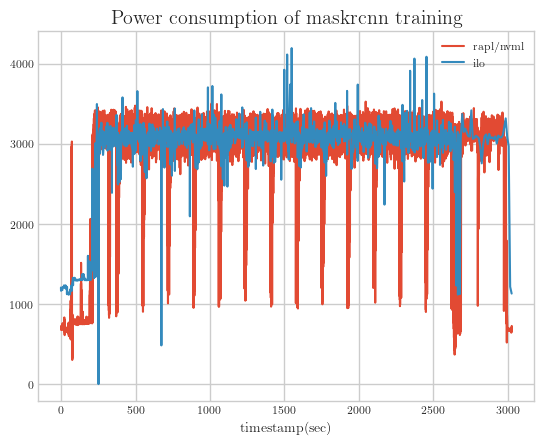

In [23]:
fig, ax = plt.subplots()
data = power.groupby(["job", "timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power(W)", data=data, kind="line", label="rapl/nvml",height=6, aspect=15/8)
data.plot(ax=ax, x="timestamp(sec)", y="power(W)", label="rapl/nvml")
data = ilo_power.groupby(["job", "timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power_watt", data=data, kind="line", label="ilo",height=6, aspect=15/8)
data.plot(ax=ax, x="timestamp(sec)", y="power_watt", label="ilo")
ax.set(title="Power consumption of maskrcnn training")
# ax._legend.remove()

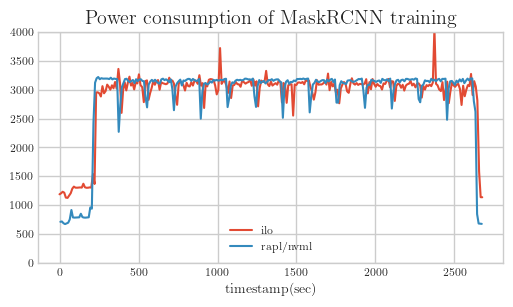

In [28]:
fig, ax = plt.subplots(figsize=(6,3))
jobid = 0

data = ilo_power[ilo_power["job"]==ilo_power["job"].values[jobid]]
data_ilo = data.set_index(pd.to_datetime(data["timestamp"], unit="s")).rename(columns={"timestamp":"coucou"}).drop(columns=["coucou"])
data_ilo.resample("10s").mean()
# data = ilo_power[ilo_power["job"]==ilo_power["job"].values[jobid]].groupby(["timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power_watt", data=data_ilo, kind="line", label="ilo",height=6, aspect=15/8)
data_ilo.plot(ax=ax, x="timestamp(sec)", y="power_watt", label="ilo")

data = power[power["job"]==power["job"].values[jobid]]
data = data.set_index(pd.to_datetime(data["timestamp"], unit="ms")).rename(columns={"timestamp":"coucou"}).drop(columns=["coucou"])
data_power = data.resample("10s", origin=data_ilo.index[0]).mean()
# data_power = data_power.groupby(["timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)") # "job", 
# sns.relplot(ax=ax, x="timestamp(sec)", y="power(W)", data=data_power, kind="line", label="rapl/nvml",height=6, aspect=15/8)
data_power.plot(ax=ax, x="timestamp(sec)", y="power(W)", label="rapl/nvml")

ax.set(title="Power consumption of MaskRCNN training")
ax.set_ylim(0, 4000)
# ax._legend.remove()
plt.savefig(f"{graph_dir}/ilo_maskrcnn.png", dpi=300)
plt.savefig(f"{graph_dir}/ilo_maskrcnn.pdf", dpi=300)

In [24]:
power.job.unique(), ilo_power.job.unique()

(array([126854, 126855, 126856, 126857, 126858, 126859, 126860, 126861,
        126862, 126863]),
 array([126854, 126855, 126856, 126857, 126858, 126859, 126860, 126861,
        126862, 126863]))